In [1]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


## Data prep

In [2]:
path = untar_data(URLs.ML_100k)

In [3]:
path

Path('C:/Users/marcinzi/.fastai/data/ml-100k')

In [7]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie_id','rating','timestamp'])

movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie_id','title'), header=None)

ratings = ratings.merge(movies)
ratings.head()

,user,movie_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [8]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,782,Starship Troopers (1997),2
1,943,Judge Dredd (1995),3
2,758,Mission: Impossible (1996),4
3,94,Farewell My Concubine (1993),5
4,23,Psycho (1960),4
5,296,Secrets & Lies (1996),5
6,940,"American President, The (1995)",4
7,334,Star Trek VI: The Undiscovered Country (1991),1
8,380,Braveheart (1995),4
9,690,So I Married an Axe Murderer (1993),1


## Factors foundations

In [13]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [16]:
#equivalence of lookup and one-hot encoding

print(user_factors[3])
print(one_hot(3, n_users).float() @ user_factors)

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])
tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])


## Dot-Product model

In [55]:
class DotProductModel(Module):

    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
    
    def predict(self, u, m):
        u_f = self.user_factors(u)
        m_f = self.movie_factors(m)
        u_b = self.user_bias(u).squeeze() # we're squeezing that 2D [n_users x 1] to n_users
        m_b = self.movie_bias(m).squeeze()

        return (u_f * m_f).sum(dim=1) + u_b + m_b

    def forward(self, model_input):
        u = model_input[:,0]
        m = model_input[:,1]
        preds = self.predict(u, m) 
        return sigmoid_range(preds, 0.5, 5.5)
    
# model input is a 2-column tensor of shape (batch_size, 2) 
# taking batch_size of user_ids and movie_ids
x, y = dls.one_batch()
print(x.shape)
print(y.shape)

model = DotProductModel(n_users, n_movies, 50)

torch.Size([64, 2])
torch.Size([64, 1])
tensor([0, 1, 2])
users=tensor([[-0.0128, -0.0031,  0.0173,  0.0109, -0.0029,  0.0002,  0.0151, -0.0146,
         -0.0052,  0.0090,  0.0118,  0.0098,  0.0045,  0.0098,  0.0055,  0.0093,
          0.0052, -0.0146, -0.0072,  0.0017, -0.0063,  0.0023,  0.0041, -0.0095,
          0.0138,  0.0067,  0.0054,  0.0114,  0.0084,  0.0169,  0.0085, -0.0171,
         -0.0057,  0.0119, -0.0017,  0.0018, -0.0035,  0.0150,  0.0015, -0.0115,
         -0.0120, -0.0061,  0.0063, -0.0145, -0.0034,  0.0133, -0.0105,  0.0024,
         -0.0115, -0.0058],
        [-0.0007,  0.0142,  0.0169, -0.0008,  0.0014,  0.0108, -0.0057, -0.0025,
          0.0146, -0.0153, -0.0007, -0.0013, -0.0038,  0.0060, -0.0142,  0.0044,
         -0.0161,  0.0165, -0.0100, -0.0073, -0.0068,  0.0142, -0.0055, -0.0051,
          0.0176,  0.0014,  0.0040, -0.0060,  0.0051, -0.0052,  0.0009, -0.0041,
          0.0087, -0.0105,  0.0105,  0.0094, -0.0023, -0.0188, -0.0009, -0.0061,
          0.0111,

In [56]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(10, 5e-3, wd=0.1)


epoch,train_loss,valid_loss,time
0,1.004221,0.997906,00:13
1,0.761130,0.893282,00:15
2,0.585090,0.881871,00:16
3,0.501550,0.889320,00:13
4,0.409780,0.886151,00:14
5,0.377758,0.885730,00:14
6,0.339033,0.882384,00:15
7,0.320276,0.876451,00:16
8,0.284226,0.876472,00:14
9,0.282942,0.876241,00:13


## Results interpretation

Bias interpretation is very simple

In [67]:
movie_bias = learn.model.movie_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=False)[:10]
[dls.classes['title'][i] for i in idxs]

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Showgirls (1995)',
 'Children of the Corn: The Gathering (1996)',
 'Cable Guy, The (1996)',
 'Grease 2 (1982)',
 "Gone Fishin' (1997)",
 'Crow: City of Angels, The (1996)',
 'Spice World (1997)',
 "McHale's Navy (1997)",
 'Robocop 3 (1993)']

Factors interpretation is very difficult.

One can transform 50D matrix to 2D or 3D using PCA method.
Then plot and try to interpret.

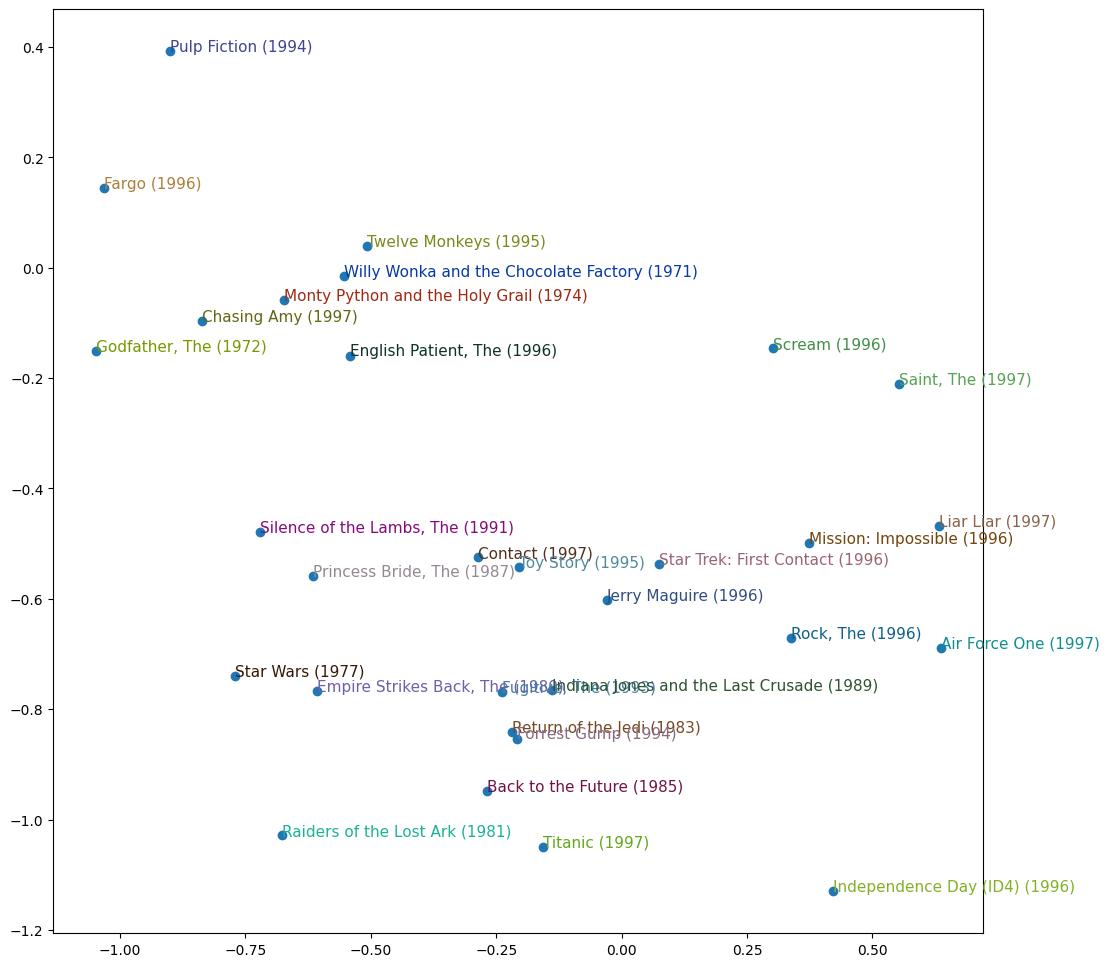

In [ ]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors.weight[top_idxs].cpu().detach()
fac0, fac1 = movie_w.pca(2).t()

idxs = list(range(30))

X=fac0[idxs]
Y=fac1[idxs]

plt.figure(figsize=(12,12))
plt.scatter(X, Y)

for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)

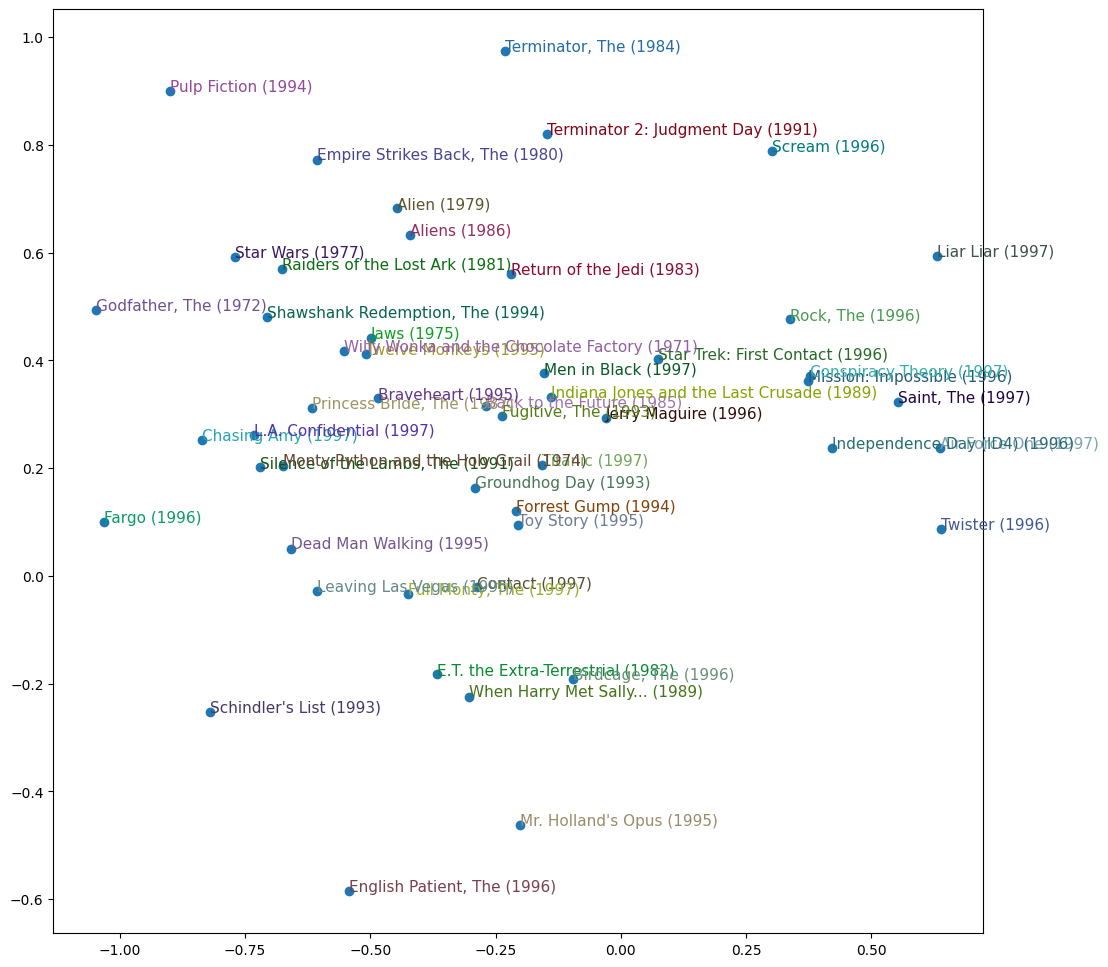

In [97]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors.weight[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collaboratrive filtering behind FastAI facade

In [98]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.896760,0.944213,00:14
1,0.674330,0.886002,00:14
2,0.517675,0.864789,00:15
3,0.456661,0.853877,00:14
4,0.448993,0.850001,00:13


In [99]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [100]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:10]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Rear Window (1954)',
 "Schindler's List (1993)",
 'Good Will Hunting (1997)',
 'L.A. Confidential (1997)',
 'Star Wars (1977)',
 'Titanic (1997)',
 'As Good As It Gets (1997)',
 'Boot, Das (1981)',
 'Godfather, The (1972)']

In [105]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx])
idx = distances.argsort(descending=True)[:10]
dls.classes['title'][idx]

(#10) ['Silence of the Lambs, The (1991)','Great Escape, The (1963)','Candidate, The (1972)','Shawshank Redemption, The (1994)',"One Flew Over the Cuckoo's Nest (1975)",'To Kill a Mockingbird (1962)','Gandhi (1982)','When We Were Kings (1996)','Glory (1989)','Ben-Hur (1959)']

## Bootstraping and Reinforcing Loops problems

### Bootstraping
Where to take the embedding vector for a new user/movie from?
- Can interpolate from other data.
- Can create new model to predict the embedding from a questionare

### Reinforcing Loops
Representation bias in data.
Anime-skewed recommendation systems.
Human in the loop.

## Deep learning for Collaborative filtering

First tensor.shape explanations.

We fix batch_size. Take same amount of users and movies.
We have counts of unique users and movies. We pick different embedding sizes for them.


In [125]:
u_size, m_size = get_emb_sz(dls) # suggested embeddings

u_factors = Embedding(*u_size)   # 944 unique users  x  recommended 74 factors
m_factors = Embedding(*m_size)   # 1665 unique movies x  recommended 102 factors

t = tensor([0,1,2])              # example batch to pick out 3 users and 3 movies

us = u_factors(t)                   # user pick, 3x  74 factors
ms = m_factors(t)                   # movies pick, 3x  102 factors

r = torch.cat((us,  ms), dim=1)     # concat on columns ->  3x (74 + 102)

u_size, m_size, t.shape, us.shape, ms.shape, r.shape

((944, 74),
 (1665, 102),
 torch.Size([3]),
 torch.Size([3, 74]),
 torch.Size([3, 102]),
 torch.Size([3, 176]))

In [ ]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),  # [1] means take factor sizes
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))    # concatenate embeddings of the batch and throw into NN
        return sigmoid_range(x, *self.y_range)

In [ ]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100])
learn.fit_one_cycle(15, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.909266,1.004329,00:17
1,0.906213,0.938974,00:18
2,0.862823,0.941975,00:23
3,0.850692,0.919474,00:19
4,0.813137,0.897428,00:17
5,0.811839,0.911253,00:21
6,0.753760,0.902390,00:16
7,0.753346,0.903496,00:20
8,0.742698,0.899126,00:19
9,0.731573,0.896568,00:21


: 